In [1]:
import os
import image_processing
import cupy as cp

In [2]:
file_path = "data/lidar/Job1051007_34077_04_88.laz"

min_x_extent = 712160
max_x_extent = 712230
min_y_extent = 33100
max_y_extent = 33170

grid_gen = image_processing.GridGenerator(
    file_path, min_x_extent, max_x_extent, min_y_extent, max_y_extent
)

resolution = 0.05  # meters

pts_array = grid_gen.create_point_array()
grid_x, grid_y, grid_z = grid_gen.gen_grid(resolution, z=pts_array)

Directory to store grids created: generated_grids


In [3]:
grid_z_gpu = cp.asarray(grid_z)

mapper = image_processing.DepthMapper(grid_z_gpu)

subfolder_path = 'data/CB_03_20220909212130_20220910054130'
labels_rects_zarr_folder = os.path.join(subfolder_path, "zarr", "labels_rects")

# Check if the labels_rects folder exists
if os.path.exists(labels_rects_zarr_folder):
    # print(f"Processing folder {subfolder}.")
    depth_map_zarr_save_dir = os.path.join(
        subfolder_path, "zarr", "depth_maps_updated"
    )
    pond_edge_elev_plot_dir = os.path.join(subfolder_path, 'plots', 'edge_histograms')
    mapper.process_depth_maps(labels_rects_zarr_folder, depth_map_zarr_save_dir, pond_edge_elev_plot_dir, depth_mask_array=True, depth_mask_path='depth_mask_array.npy')

In [2]:
import zarr
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from pathlib import Path
import rioxarray
import xarray as xr
import numpy as np
from affine import Affine
import cmocean

# Imports needed for the manual colorbar
from matplotlib import cm
from matplotlib.colors import Normalize


In [3]:
def plot_flood_depth_map(depth_array, min_x, max_x, min_y, max_y,
                                 resolution_m=0.05, bbox_crs='EPSG:32119', output_folder='figures'):
    """
    Plots a flood numpy array, correcting for a "bottom-left" array origin by
    flipping the array vertically before georeferencing.

    Args:
        numpy_array (np.ndarray): The raw numpy array, assumed to have a (0,0) origin
                                  at the bottom-left.
        ... (other args are the same) ...
    """

    # 1. Build and georeferenced the DataArray.
    # --- THE CRITICAL FIX BASED ON YOUR INSIGHT ---
    # Vertically flip the array to convert from a "bottom-left" origin to the
    # "top-left" origin expected by geospatial raster standards.
    data_for_xarray = np.flipud(depth_array).astype(float)

    transform = Affine(resolution_m, 0.0, min_x, 0.0, -resolution_m, max_y)
    da_hmax = xr.DataArray(
        data=data_for_xarray,
        dims=["y", "x"],
        name='flood_depth'
    )
    da_hmax.rio.write_crs(bbox_crs, inplace=True)
    da_hmax.rio.write_transform(transform, inplace=True)
    da_hmax.rio.write_nodata(np.nan, inplace=True)

    # 2. Reproject the raster to Web Mercator.
    da_hmax_mercator = da_hmax.rio.reproject(3857)

    # 3. Create the plot axes
    fig, ax = plt.subplots(figsize=(10, 10))

    # 4. Get the spatial bounds and data from the reprojected raster.
    minx, miny, maxx, maxy = da_hmax_mercator.rio.bounds()
    data_to_plot = da_hmax_mercator.to_numpy()

    # 5. Set the axis limits.
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # 6. Add the basemap FIRST.
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, zorder=1)

    vmin = 0
    vmax = 0.25
    
    # 7. Use ax.imshow() to plot the data ON TOP.
    im = ax.imshow(
        data_to_plot,
        extent=(minx, maxx, miny, maxy),
        cmap=cmocean.cm.dense,
        vmin=vmin,
        vmax=vmax,
        alpha=0.7,
        interpolation='none',
        zorder=10
    )

    ax.text(
            0.05,
            0.95,
            f"Spatial Extent ($m^2$): {round((np.sum(~np.isnan(depth_array))) * 0.0025, 2)}",
            transform=ax.transAxes,
            fontsize=12,
            verticalalignment="top",
            bbox=dict(facecolor="white", alpha=0.8, edgecolor="black"),
        )
    
    # 8. Manually create a colorbar.
    cbar = fig.colorbar(im, ax=ax, shrink=0.6, aspect=30)
    cbar.set_label('Depth (m)')
    
    # 9. Clean up and save
    png_path = Path(output_folder) / "flood_map_final_depth_95.png"
    png_path.parent.mkdir(parents=True, exist_ok=True)

    ax.set_title('')
    ax.set_axis_off()
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    print(f"Plot created successfully and saved to {png_path}.")

In [4]:

def plot_flood_wse_map(depth_array, min_x, max_x, min_y, max_y,
                                 resolution_m=0.05, bbox_crs='EPSG:32119', output_folder='figures'):
    """
    Plots a flood numpy array, correcting for a "bottom-left" array origin by
    flipping the array vertically before georeferencing.

    Args:
        numpy_array (np.ndarray): The raw numpy array, assumed to have a (0,0) origin
                                  at the bottom-left.
        ... (other args are the same) ...
    """

    # 1. Build and georeferenced the DataArray.
    # --- THE CRITICAL FIX BASED ON YOUR INSIGHT ---
    # Vertically flip the array to convert from a "bottom-left" origin to the
    # "top-left" origin expected by geospatial raster standards.
    data_for_xarray = np.flipud(depth_array).astype(float)

    transform = Affine(resolution_m, 0.0, min_x, 0.0, -resolution_m, max_y)
    da_hmax = xr.DataArray(
        data=data_for_xarray,
        dims=["y", "x"],
        name='flood_depth'
    )
    da_hmax.rio.write_crs(bbox_crs, inplace=True)
    da_hmax.rio.write_transform(transform, inplace=True)
    da_hmax.rio.write_nodata(np.nan, inplace=True)

    # 2. Reproject the raster to Web Mercator.
    da_hmax_mercator = da_hmax.rio.reproject(3857)

    # 3. Create the plot axes
    fig, ax = plt.subplots(figsize=(10, 10))

    # 4. Get the spatial bounds and data from the reprojected raster.
    minx, miny, maxx, maxy = da_hmax_mercator.rio.bounds()
    data_to_plot = da_hmax_mercator.to_numpy()

    # 5. Set the axis limits.
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # 6. Add the basemap FIRST.
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, zorder=1)
    
    vmin=np.nanmin(data_to_plot)
    vmax=np.nanmax(data_to_plot)
    
    # 7. Use ax.imshow() to plot the data ON TOP.
    im = ax.imshow(
        data_to_plot,
        extent=(minx, maxx, miny, maxy),
        cmap='Blues',
        alpha=0.7,
        interpolation='none',
        zorder=10
    )

    ax.text(
            0.05,
            0.95,
            f"Spatial Extent ($m^2$): {round((np.sum(~np.isnan(depth_array))) * 0.0025, 2)}",
            transform=ax.transAxes,
            fontsize=12,
            verticalalignment="top",
            bbox=dict(facecolor="white", alpha=0.8, edgecolor="black"),
        )
    
    # 8. Manually create a colorbar.
    norm = Normalize(vmin=np.nanmin(data_to_plot), vmax=np.nanmax(data_to_plot))
    # Create the colorbar
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='Blues'), ax=ax, shrink=0.6, aspect=30)
    cbar.set_label('Water Surface Elevation (m)')
    
    # 9. Clean up and save
    png_path = Path(output_folder) / "flood_map_final_wse_95.png"
    png_path.parent.mkdir(parents=True, exist_ok=True)

    ax.set_title('')
    ax.set_axis_off()
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    print(f"Plot created successfully and saved to {png_path}.")

In [7]:
min_x_extent = 712160
max_x_extent = 712230
min_y_extent = 33100
max_y_extent = 33170

zarr_store_path = 'data/CB_03_20220909212130_20220910054130/zarr/depth_maps_updated/CAM_CB_03_20220910010635_predseg_labels_rectified_wse_map_95_perc'

img_store = zarr.open(zarr_store_path, mode="r")
depth_map = img_store[:]

plot_flood_wse_map(depth_map, min_x_extent, max_x_extent, min_y_extent, max_y_extent, bbox_crs='EPSG:32119', output_folder='figures')

Plot created successfully and saved to figures/flood_map_final_wse_95.png.


In [7]:
import json
import numpy as np
import cv2 # OpenCV


In [8]:

def create_mask_from_labelme(json_path: str, label_to_mask: str) -> np.ndarray:
    """
    Parses a LabelMe JSON file and creates a binary mask for a specific label.

    Args:
        json_path (str): The full path to the LabelMe JSON file.
        label_to_mask (str): The label of the shape to be masked (e.g., 'roadway').

    Returns:
        np.ndarray: A 2D NumPy array representing the binary mask. 
                    Pixels inside the polygon are 255 (white), and 0 (black) otherwise.
                    Returns an empty array if the JSON is invalid or the label is not found.
    """
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"Error: JSON file not found at {json_path}")
        return np.array([])
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {json_path}")
        return np.array([])

    # Get image dimensions from the JSON file
    height = data.get('imageHeight')
    width = data.get('imageWidth')

    if height is None or width is None:
        print("Error: 'imageHeight' or 'imageWidth' not found in JSON file.")
        return np.array([])

    # Create a blank mask with the same dimensions as the image
    mask = np.zeros((height, width), dtype=np.uint8)

    # Find all shapes that match the target label
    polygons_to_draw = []
    for shape in data.get('shapes', []):
        if shape.get('label') == label_to_mask:
            # LabelMe points are a list of [x, y] coordinates
            points = shape.get('points')
            if points:
                # Convert points to a NumPy array of integer type, required by fillPoly
                polygons_to_draw.append(np.array(points, dtype=np.int32))

    if not polygons_to_draw:
        print(f"Warning: No shapes found with label '{label_to_mask}' in {json_path}")
        return mask # Return the empty mask

    # Draw the filled polygons on the mask
    # The color (255) makes the masked area white
    cv2.fillPoly(mask, polygons_to_draw, 255)

    return mask

In [9]:
import json
import numpy as np
import cv2 # OpenCV
import matplotlib.pyplot as plt
import os

def create_mask_from_labelme(json_path: str, label_to_mask: str) -> np.ndarray:
    """
    Parses a LabelMe JSON file and creates a binary mask for a specific label.

    Args:
        json_path (str): The full path to the LabelMe JSON file.
        label_to_mask (str): The label of the shape to be masked (e.g., 'roadway').

    Returns:
        np.ndarray: A 2D NumPy array representing the binary mask. 
                    Pixels inside the polygon are 255 (white), and 0 (black) otherwise.
                    Returns an empty array if the JSON is invalid or the label is not found.
    """
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"Error: JSON file not found at {json_path}")
        return np.array([])
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {json_path}")
        return np.array([])

    # Get image dimensions from the JSON file
    height = data.get('imageHeight')
    width = data.get('imageWidth')

    if height is None or width is None:
        print("Error: 'imageHeight' or 'imageWidth' not found in JSON file.")
        return np.array([])

    # Create a blank mask with the same dimensions as the image
    mask = np.zeros((height, width), dtype=np.uint8)

    # Find all shapes that match the target label
    polygons_to_draw = []
    for shape in data.get('shapes', []):
        if shape.get('label') == label_to_mask:
            # LabelMe points are a list of [x, y] coordinates
            points = shape.get('points')
            if points:
                # Convert points to a NumPy array of integer type, required by fillPoly
                polygons_to_draw.append(np.array(points, dtype=np.int32))

    if not polygons_to_draw:
        print(f"Warning: No shapes found with label '{label_to_mask}' in {json_path}")
        return mask # Return the empty mask

    # Draw the filled polygons on the mask
    # The color (255) makes the masked area white
    cv2.fillPoly(mask, polygons_to_draw, 1)

    # Define the output filename for the mask image
    output_filename = "roadway_mask.png"

    # Save the mask array as a grayscale PNG image
    # The function returns True if the save was successful
    success = cv2.imwrite(output_filename, mask)

    if success:
        print(f"Mask successfully saved as '{output_filename}'")
    else:
        print(f"Error: Failed to save mask to '{output_filename}'")
    
    return mask


Mask successfully saved as 'roadway_mask.png'


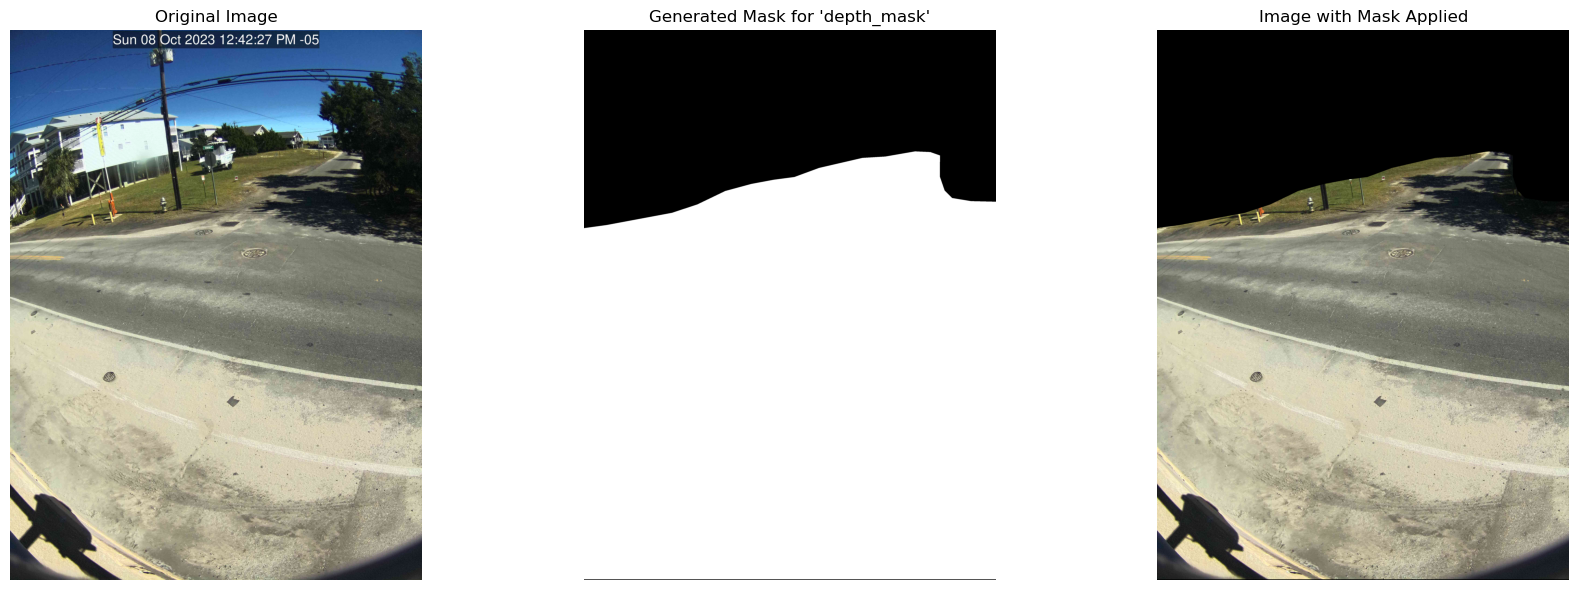

In [10]:

# --- Main Script ---

# Define the paths to your files
json_file_path = "depth_mask.json"
image_file_path = "CAM_CB_03_20231008174225.jpg"

# !!! IMPORTANT: Change this to the exact label name you used in LabelMe !!!
target_label = "depth_mask" 

# --- Check if files exist before proceeding ---
if not os.path.exists(json_file_path):
    print(f"FATAL ERROR: JSON file not found at '{json_file_path}'")
    print("Please make sure the JSON file is in the same directory as the script.")
elif not os.path.exists(image_file_path):
    print(f"FATAL ERROR: Image file not found at '{image_file_path}'")
    print("Please make sure the image file is in the same directory as the script.")
else:
    # Create the mask using the function
    roadway_mask = create_mask_from_labelme(json_file_path, target_label)

    # Load the original image
    # cv2.imread loads in BGR format by default
    image_bgr = cv2.imread(image_file_path)
    if image_bgr is None:
        print(f"Error: Failed to load image from {image_file_path}")
    else:
        # Convert to RGB for correct plotting with Matplotlib
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        # Ensure the mask and image have the same dimensions
        if roadway_mask.shape[:2] != image_rgb.shape[:2]:
            print("Error: Mask and image dimensions do not match!")
            print(f"Image shape: {image_rgb.shape}, Mask shape: {roadway_mask.shape}")
        else:
            # Apply the mask to the image using a bitwise AND operation
            # This keeps pixel values in the original image only where the mask is white (255)
            masked_image = cv2.bitwise_and(image_rgb, image_rgb, mask=roadway_mask)

            # --- Plot the results ---
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))

            # Plot 1: Original Image
            axes[0].imshow(image_rgb)
            axes[0].set_title('Original Image')
            axes[0].axis('off')

            # Plot 2: Generated Mask
            # cmap='gray' is important for displaying a 2D array correctly
            axes[1].imshow(roadway_mask, cmap='gray')
            axes[1].set_title(f"Generated Mask for '{target_label}'")
            axes[1].axis('off')

            # Plot 3: Masked Image
            axes[2].imshow(masked_image)
            axes[2].set_title('Image with Mask Applied')
            axes[2].axis('off')

            plt.tight_layout()
            plt.show()

In [11]:
intrinsics = np.array([3040, # number of pixel columns
                       4056, # number of pixel rows
                       1503.0136, # U component of principal point
                       2163.4301, # V component of principal point
                       2330.4972, # U component of focal length
                       2334.0017, # V component of focal length
                       -0.3587, # radial distortion 
                       0.1388, # radial distortion
                       -0.0266, # radial distortion
                       -0.0046, # tangential distortion
                       0.0003 # tangential distortion
                       ])
#CB03 Extrinsics
extrinsics = np.array([712159.597863065, # camera x in world
                       33136.9994153273, # camera y in world
                       3.72446811607855, # camera elev in world
                       1.30039127961854, # azimuth
                       1.02781393967485, # tilt
                       -0.160877893129538 # roll/swing
                       ])

rectifier = image_processing.ImageRectifier(intrinsics, extrinsics, grid_x, grid_y, grid_z, True)

depth_mask_rectified = rectifier.merge_rectify('roadway_mask.png', True)

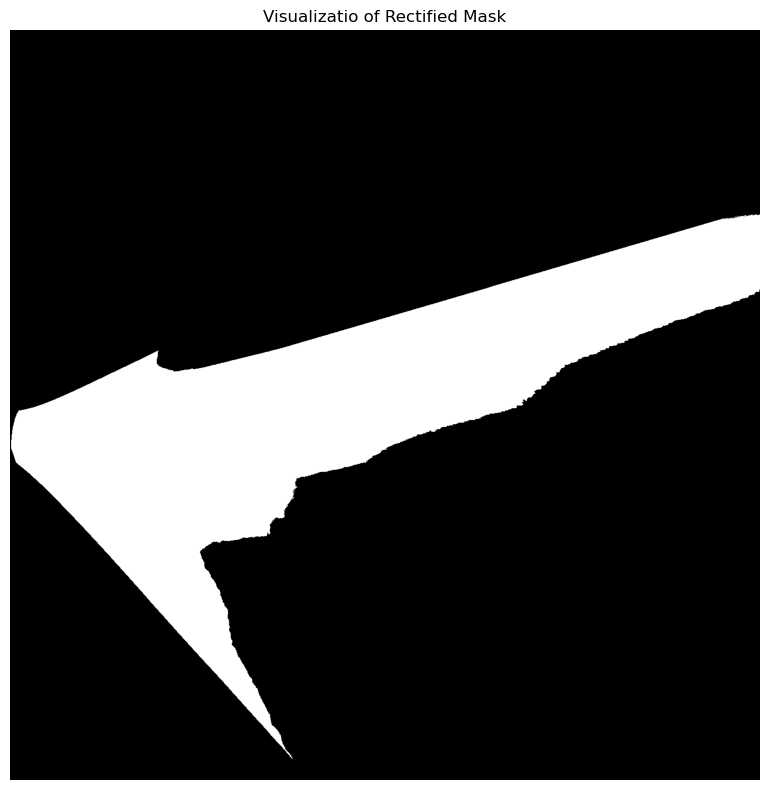

In [12]:
# 2. Plot the array using Matplotlib
fig, ax = plt.subplots(figsize=(10, 8)) # Adjust figsize as needed

# 'imshow' is the function to display image data (our array)
# 'cmap="gray"' ensures it's displayed in black and white, not a default colormap
ax.imshow(depth_mask_rectified.get(), cmap='gray')

# Add a title for clarity
ax.set_title("Visualizatio of Rectified Mask")

# Hide the axis ticks and labels for a cleaner look
ax.axis('off')

# Display the plot window
plt.tight_layout()
plt.show()

In [13]:
np.save('depth_mask_array', depth_mask_rectified.get())

In [14]:
np.unique(depth_mask_rectified)

array([0, 1], dtype=uint8)

In [15]:
depth_mask_rectified.shape

(1400, 1400, 1)